In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

In [10]:
os.chdir('/home/adri/Projects/phd/bias_2')

In [11]:
# Read signling data
path = 'data/raw/alanin_scanning-cuantitative_values-emax_ec50.csv'
signaling_df = pd.read_csv(path)

# Remove mutations that are not alanin scan
alanin_scan_mask = signaling_df.Mutant.apply(
    lambda x: bool(re.match('([A-Z])(\d+)$', str(x))))
signaling_df = signaling_df.loc[alanin_scan_mask]

# Remove non usefull columns
cols_of_interst = ['Position', 'Emax_avg_corr_Gi2_HU210',
                   'Emax_avg_corr_bArr1_HU210']
signaling_df = signaling_df[cols_of_interst]

# Change column names
signaling_df.columns = ['position', 'gi_emax', 'barr_emax']

In [12]:
# Set boolean masks for biased and wt
barr_loss_mask = signaling_df.barr_emax == 0
gi_loss_mask = signaling_df.gi_emax == 0


# Create a field wih categorical signal information
signaling_df['profile'] = 'wt'
signaling_df.loc[barr_loss_mask & ~gi_loss_mask, 'profile'] = 'Gi preferring'
signaling_df.loc[~barr_loss_mask & gi_loss_mask, 'profile'] = 'Barr preferring'
signaling_df.loc[barr_loss_mask & gi_loss_mask, 'profile'] = 'Both loss'

In [13]:
path = 'data/processed/features_new.csv'
features = pd.read_csv(path, index_col=0)
simulated_mutants = features.mutant_id.unique()
simulated_mutants = simulated_mutants.astype(str)

/tmp/ipykernel_2437515/4220519429.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  features = pd.read_csv(path, index_col=0)


In [14]:
signaling_df['simulated'] = signaling_df.position.apply(
    lambda x: str(x) in simulated_mutants)

In [15]:
signaling_df['simulated'] = signaling_df.simulated.apply(
    lambda x: 'simulated' if x else 'not simulated')

In [16]:
signaling_df

,position,gi_emax,barr_emax,profile,simulated
0,1,0.825515,1.122299,wt,not simulated
1,2,0.615114,0.907206,wt,not simulated
2,3,1.072523,0.826491,wt,not simulated
3,4,1.203155,1.060027,wt,not simulated
4,5,1.003370,1.008177,wt,not simulated
...,...,...,...,...,...
367,356,1.062682,0.976102,wt,not simulated
368,357,1.167825,0.747814,wt,not simulated
369,358,1.107844,0.862811,wt,not simulated
370,359,1.158079,0.744454,wt,not simulated


In [17]:
signaling_df = signaling_df.sort_values('simulated')

In [56]:
# Multiply gi_emax and barr_emax by 100
signaling_df.gi_emax = signaling_df.gi_emax * 100
signaling_df.barr_emax = signaling_df.barr_emax * 100
signaling_df

,position,gi_emax,barr_emax,profile,simulated
0,1,82.551498,112.229869,wt,not simulated
249,240,87.904926,114.488286,wt,not simulated
248,239,111.916147,139.257314,wt,not simulated
247,238,155.739864,162.899155,wt,not simulated
246,237,93.269729,207.798143,wt,not simulated
...,...,...,...,...,...
32,33,104.517418,94.548377,wt,simulated
212,203,95.139658,143.534599,wt,simulated
208,199,95.290170,0.000000,Gi preferring,simulated
114,109,137.929062,0.000000,Gi preferring,simulated


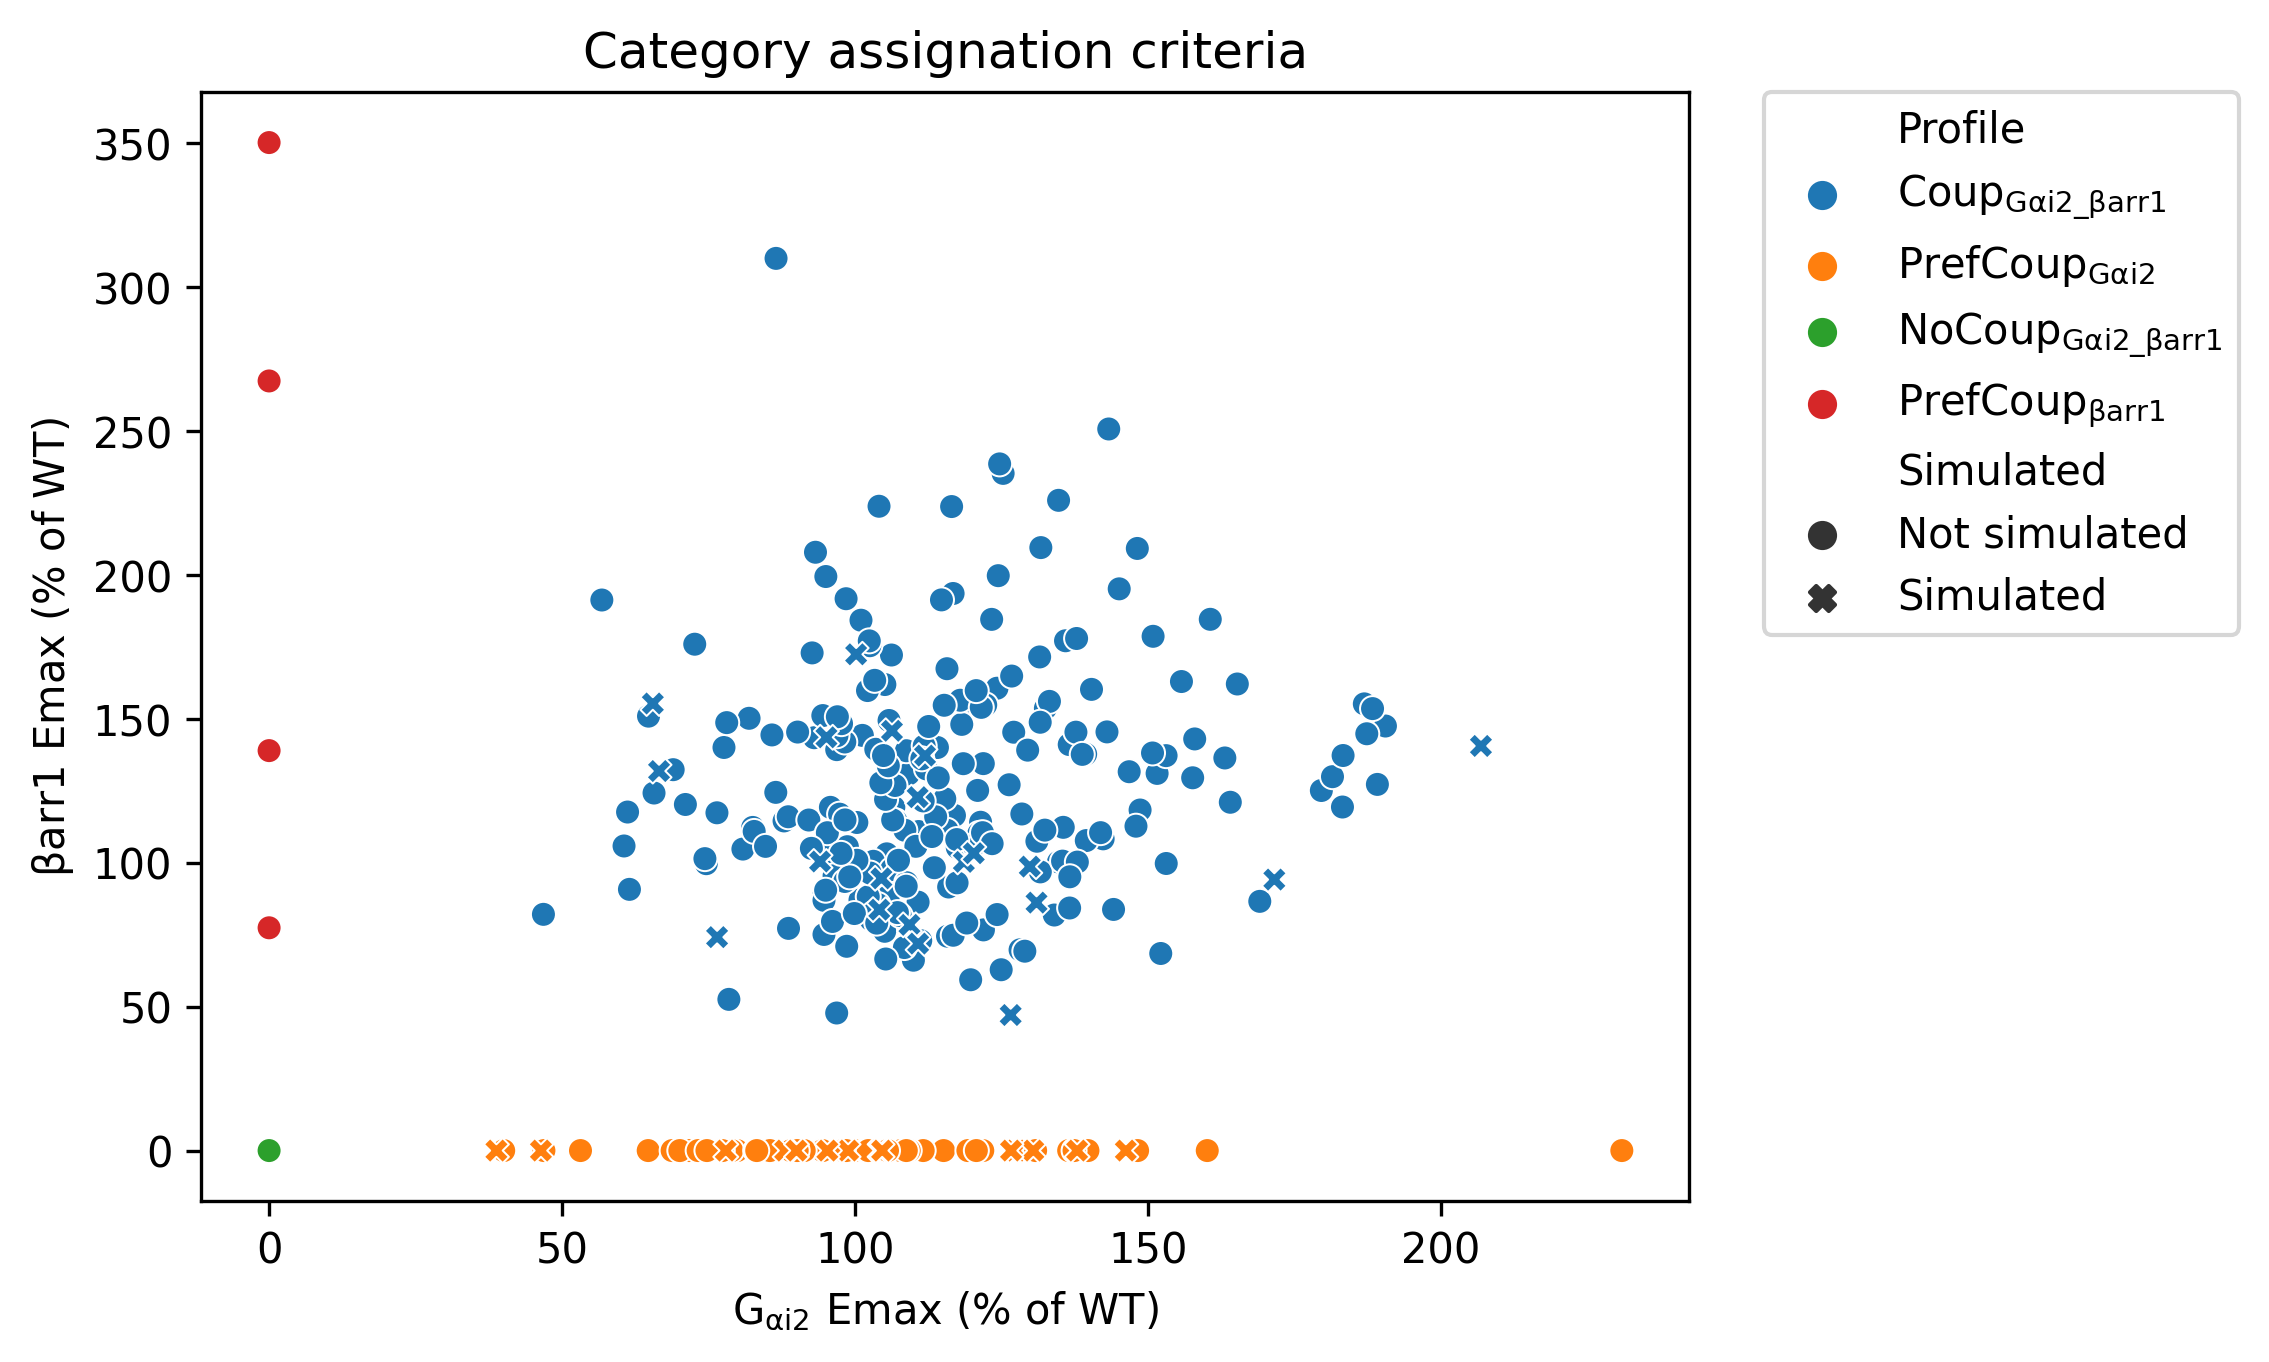

In [58]:
plt.figure(dpi=300)
sns.scatterplot(data=signaling_df, x='gi_emax', y='barr_emax',
                hue='profile', style='simulated')
plt.xlabel(r'$\mathrm{G_{\alpha i2}\ Emax}$ (% of WT)')
plt.ylabel(r'$\mathrm{\beta arr1\ Emax}$ (% of WT)')
plt.title("Category assignation criteria")
# change location and labels of legend
new_labels = ["Profile",
              r'$\mathrm{Coup_{G\alpha i2\_\beta arr1}}$',
              r'$\mathrm{PrefCoup_{G\alpha i2}}$',
              r'$\mathrm{NoCoup_{G\alpha i2\_\beta arr1}}$',
              r'$\mathrm{PrefCoup_{\beta arr1}}$',
              "Simulated",
              "Not simulated", "Simulated"]
l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

for i, text in enumerate(l.get_texts()):
    text.set_text(new_labels[i])

plt.show()